# Machine Learning
* loading dataset and applying preprocessing
* Training multiple ML models
    * Looking at metrics for comparison of models
* Hyperparameter training on best model

### Loading dataset using module to apply preprocessing
* Development_Process.py

In [22]:
#libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

In [3]:
#importing module that wraps preprocessing steps
import Development_Preprocess as devp

In [9]:
#reimport if necessary (edit file after already imported)
import importlib
importlib.reload(devp)

<module 'Development_Preprocess' from '/Users/Temp/Data4380/Tabular Project - Development Dataset/Development_Preprocess.py'>

### Binary Classification

In [10]:
#loading dataset
donor=pd.read_csv('bio_data_table.csv')
giving=pd.read_csv('giving_data_table.csv')
df=devp.load_preprocess(donor,giving,binary=True,cities=False)
df.head()

/Users/Temp/Data4380/Tabular Project - Development Dataset/Development_Preprocess.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past['Time Between']=past.groupby('ID')['gift date'].diff().dt.days
/Users/Temp/Data4380/Tabular Project - Development Dataset/Development_Preprocess.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past['Hard Credit']=past['credit Type']=='Hard-Credit'
/Users/Temp/Data4380/Tabular Project - Development Dataset/Development_Preprocess.py:75: SettingWithCopyWarning: 
A val

,Median_Time_Between,Average_Time_Between,Average_Amount,Time from First Gift,0,1,2,3,4,5,...,86,87,88,89,90,91,92,93,94,Give in 2020?
0,1.000000,1.000000,0.00000,1.000000,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.113111,0.113111,0.00028,0.734134,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.113111,0.113111,0.00028,0.734134,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,1.000000,0.00000,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,1.000000,0.00000,1.000000,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Binary Classification: Models

In [65]:
#choosing ML algorithms for testing
names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
]

#creating classifier instances for each ML alg
classifier_instances = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
]

param_grids = [
    {'n_neighbors':[50,100,150,200]},
    {'max_depth':[None,5,10],'min_samples_split':[5,10,15],'min_samples_leaf':[1,3,5]},
    {'max_depth':[None,5,10],'n_estimators':[100,200,300]}
]

#creating dictionary of classifier name and instance
classifiers = dict(zip(names,zip(classifier_instances,param_grids)))

In [66]:
# iterate over datasets
import sys

def fit_all(dataset,classifiers, max_cls=None):
    scores=dict()
    curves=dict()
    # preprocess dataset, split into training and test part
    X = dataset.iloc[:,:-1] #excluding target var
    y = dataset.iloc[:,-1:] #only target var
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=123)

    # iterate over classifiers
    for cls_cnt,(cls_name, (clf,param_grid)) in enumerate(classifiers.items()):
        print(cls_cnt,"Running classifier",cls_name,"on dataset",". N_Train = ",X_train.shape[0] )
        sys.stdout.flush()

        #hyperparameter training
        grid=GridSearchCV(clf, param_grid, cv=5)
        grid.fit(X_train.to_numpy(), y_train.to_numpy())
        best_model = grid.best_estimator_

        best_clf = CalibratedClassifierCV(best_model, cv=5) #help smooth out roc curve; calibrate probabilities
        clf_0 = make_pipeline(StandardScaler(),best_clf)
        clf_0.fit(X_train.to_numpy(), y_train.to_numpy().reshape((len(y_train),)))
        score = clf_0.score(X_test.to_numpy(), y_test.to_numpy())

        scores[cls_name]=dict()
        scores[cls_name]['Score'] = score
        scores[cls_name]['Accuracy']=accuracy_score(y_test.to_numpy(),clf_0.predict(X_test.to_numpy()))
        scores[cls_name]['Precision']=precision_score(y_test.to_numpy(),clf_0.predict(X_test.to_numpy()))
        scores[cls_name]['Recall']=recall_score(y_test.to_numpy(),clf_0.predict(X_test.to_numpy()))
        scores[cls_name]['F1']=f1_score(y_test.to_numpy(),clf_0.predict(X_test.to_numpy()))
        scores[cls_name]['AUC-ROC']=roc_auc_score(y_test.to_numpy(),clf_0.predict(X_test.to_numpy()))
        scores[cls_name]['ConfusionMatrix']=confusion_matrix(y_test.to_numpy(),clf_0.predict(X_test.to_numpy()))

        curves[cls_name]=dict()
        curves[cls_name]['FPR'],curves[cls_name]['TPR'],curves[cls_name]['Thresholds']=roc_curve(y_test.to_numpy(),clf_0.predict_proba(X_test.to_numpy())[:, 1])
        if max_cls:
            if cls_cnt>max_cls:
                print("Max Classifiers Reached.")
                sys.stdout.flush()
                break

    return scores, curves

In [67]:
scores, curves = fit_all(df,classifiers,2)

0 Running classifier Nearest Neighbors on dataset . N_Train =  70000


/Users/Temp/Data4380/.venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/Temp/Data4380/.venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/Temp/Data4380/.venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/Temp/Data4380/.venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was 

1 Running classifier Decision Tree on dataset . N_Train =  70000
2 Running classifier Random Forest on dataset . N_Train =  70000


/Users/Temp/Data4380/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Temp/Data4380/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Temp/Data4380/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Temp/Data4380/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

In [68]:
from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(list(map(lambda x: [x[0]]+x[1],zip(scores.keys(),map(lambda x: list(x.values()),scores.values())))), 
                               tablefmt='html',
                               headers=[" "]+list(next(iter(scores.items()))[1].keys()))))


,Score,Accuracy,Precision,Recall,F1,AUC-ROC,ConfusionMatrix
Nearest Neighbors,0.664533,0.664533,0.585902,0.908746,0.712457,0.683734,[[ 7468 8812] [ 1252 12468]]
Decision Tree,0.776967,0.776967,0.750374,0.767711,0.758944,0.776239,[[12776 3504] [ 3187 10533]]
Random Forest,0.675533,0.675533,0.585419,0.995554,0.737288,0.700695,[[ 6607 9673] [ 61 13659]]


K Nearest Neighbors
* AUC-ROC Score > moderate score, but model is doing more than merely guessing
* High recall, potentially overly assigning positive classification (Gives in 2020)

Decision Tree
* AUC-ROC Score > best of the bunch at 0.776239
* Has best scores over all metrics besides recall
* Unshown, but prior to hyperparameter training, AUC-ROC Score = 0.700734. Hyperparameter training increased AUC-ROC Score from 0.70 to 0.78.
    * Better model likely would depend on better preprocessing

Random Forest
* AUC-ROC Score > similar in performance to K Nearest Neighbors, lags behind just slightly
* Even higher recall score thatn K Nearest Neighbors

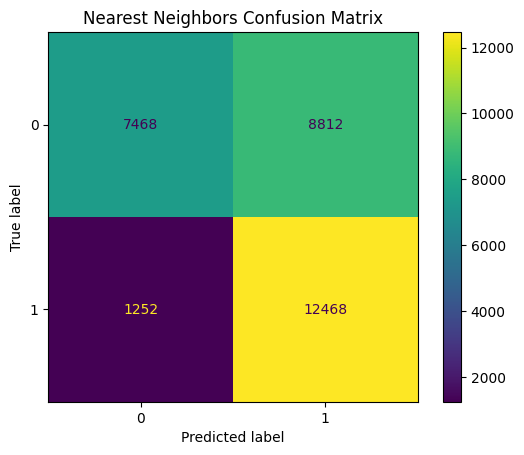

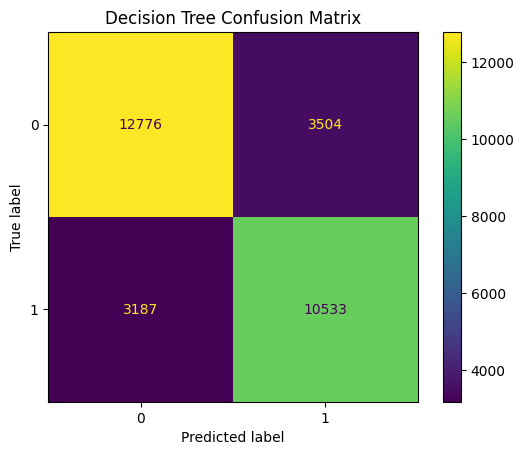

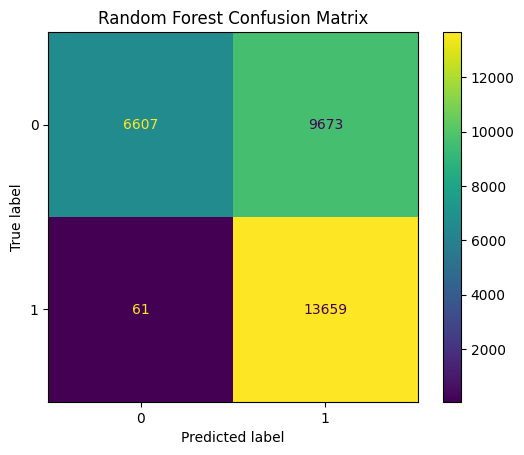

In [69]:
for cls_cnt,(cls_name, clf) in enumerate(classifiers.items()):
    confusion=ConfusionMatrixDisplay(scores[cls_name]['ConfusionMatrix'])
    confusion.plot()
    plt.title(f'{cls_name} Confusion Matrix')

Confusion Matrix
* Reflects numerical metrics, as expected

In [54]:
for cls_cnt,(cls_name, clf) in enumerate(classifiers.items()):
    fpr=curves[cls_name]['FPR']
    tpr=curves[cls_name]['TPR']
    auc=scores[cls_name]['AUC-ROC']
    print(f'{cls_name} : Number of distinct probabilities = {len(set(fpr))}, {len(set(tpr))}')

Nearest Neighbors : Number of distinct probabilities = 6106, 6075
Decision Tree : Number of distinct probabilities = 4946, 5830
Random Forest : Number of distinct probabilities = 5686, 5684


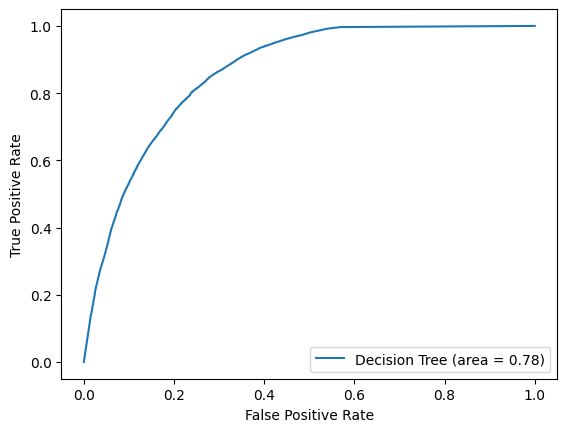

In [73]:
#Decision Tree ROC Curve
fpr=curves['Decision Tree']['FPR']
tpr=curves['Decision Tree']['TPR']
auc=scores['Decision Tree']['AUC-ROC']
plt.plot(fpr,tpr,label=f'Decision Tree (area = {auc:.2f})')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()